<a href="https://colab.research.google.com/github/Ablaze3883/NSAC-Skywalkers/blob/main/UV_X_ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyvo
!pip install aplpy



In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
from astropy.utils.data import download_file
from astropy.io import fits

import pyvo as vo
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

In [ ]:

tap_services=vo.regsearch(servicetype='table',keywords=['heasarc'])
heasarc_tables=tap_services[0].service.tables

In [ ]:
services = vo.regsearch(servicetype='scs', keywords=['zcat'])
services.to_table()['ivoid', 'short_name', 'res_title']

ivoid,short_name,res_title
object,object,object
ivo://cds.vizier/j/apj/872/134,J/ApJ/872/134,"A uniformly selected, all-sky, optical AGN catalog (Zaw+, 2019)"
ivo://cds.vizier/j/apj/872/134,J/ApJ/872/134,"A uniformly selected, all-sky, optical AGN catalog (Zaw+, 2019)"
ivo://cds.vizier/j/apj/872/134,J/ApJ/872/134,"A uniformly selected, all-sky, optical AGN catalog (Zaw+, 2019)"
ivo://cds.vizier/j/mnras/339/652,J/MNRAS/339/652,The FLASH Redshift Survey (Kaldare+ 2003)
ivo://cds.vizier/vii/259,VII/259,"6dF galaxy survey final redshift release (Jones+, 2009)"
ivo://cds.vizier/vii/259,VII/259,"6dF galaxy survey final redshift release (Jones+, 2009)"
ivo://nasa.heasarc/sixdfgs,SIXDFGS,6dFGS Galaxy Survey Final Redshift Release Catalog
ivo://nasa.heasarc/uzc,UZC,Updated Zwicky Catalog
ivo://nasa.heasarc/zcat,CFAZ,CfA Redshift Catalog (June 1995 Version)


In [ ]:
for tablename in heasarc_tables.keys():
    if "chan" in tablename:  
        print("Table {} has columns={}\n".format(
            tablename,
            sorted([k.name for k in heasarc_tables[tablename].columns ])))

Table bmwchancat has columns=['"__row"', '"__x_ra_dec"', '"__y_ra_dec"', '"__z_ra_dec"', '"time"', 'ascds_version', 'bck_counts', 'bck_hb_counts', 'bck_sb_counts', 'bii', 'chi_squared', 'count_rate', 'count_rate_error', 'counted_band1_counts', 'counted_band2_counts', 'counted_band3_counts', 'counted_band4_counts', 'counted_bck_counts', 'counted_counts', 'counts', 'counts_error', 'cross_match_flag_1', 'cross_match_flag_2', 'data_mode', 'dec', 'dec_error', 'end_time', 'error_radius', 'exposure', 'extent_flag', 'field_target', 'field_target_dec_j2000', 'field_target_nh', 'field_target_ra_j2000', 'flux', 'flux_cr_corfac', 'frame_time', 'full_band_flux', 'full_band_obs_flux', 'hb_count_rate', 'hb_count_rate_error', 'hb_counted_bck_counts', 'hb_counted_counts', 'hb_counts', 'hb_counts_error', 'hb_flux', 'hb_psf_corr_factor', 'hb_snr', 'hb_vignetting_factor', 'hb_wavelet_snr', 'lii', 'name', 'nominal_exposure', 'obsid', 'off_axis', 'psf_corr_factor', 'quality_flag_1', 'quality_flag_2', 'ra', 

In [ ]:
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("NGC 1333")
query="""SELECT ra, dec, exposure, flux, flux_lower, flux_upper FROM public.chansngcat as cat 
    where contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and cat.exposure > 0 order by cat.exposure""".format(pos.ra.deg, pos.dec.deg)
results=tap_services[0].service.run_async(query)
results.to_table()

ra,dec,exposure,flux,flux_lower,flux_upper
float64,float64,float64,float64,float64,float64


In [ ]:
uv_services=vo.regsearch(servicetype='image',keywords='galex', waveband='uv')
uv_services.to_table()['ivoid','short_name']

ivoid,short_name
object,object
ivo://archive.stsci.edu/sia/galex,GALEX
ivo://irsa.ipac/spitzer/images/lvl,LVL
ivo://irsa.ipac/wise/images/z0mgs,z0MGS
ivo://mast.stsci/siap/galex_atlas,GALEX_Atlas
ivo://nasa.heasarc/skyview/galex,GALEX


In [ ]:
uv_services.to_table()[
    np.isin(uv_services.to_table()['short_name'],b'GALEX')
    ]['ivoid','short_name','access_url']

ivoid,short_name,access_url
object,object,object
ivo://archive.stsci.edu/sia/galex,GALEX,https://mast.stsci.edu/portal/Mashup/VoQuery.asmx/SiaV1?MISSION=GALEX&
ivo://nasa.heasarc/skyview/galex,GALEX,https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl?survey=galex&


In [ ]:
galex_stsci=[s for s in uv_services if 'GALEX' in s.short_name and 'stsci' in s.ivoid][0]
galex_heasarc=[s for s in uv_services if 'GALEX' in s.short_name and 'heasarc' in s.ivoid][0]

In [ ]:
im_table_stsci=galex_stsci.search(pos=pos,size=0.1)
im_table_stsci.to_table()

collection,insName,name,posLocationRA,posLocationDec,contentLength,naxes,naxis,scale,contentType,coordFrame,projection,crpix,crval,cdmatrix,enrEMBand,enrUnits,enrValue,enrMax,enrMin,accessURL
object,object,object,float64,float64,int32,int32,object,object,object,object,bytes3,object,object,object,object,object,float64,float64,float64,object
GALEX,GALEX,nga_ngc2207-nd-int.fits.gz,94.1541111904461,-21.4480360491679,18667687,2,[3840 3840],[0.000416667 0.000416667],image/fits,ICRS,TAN,[1920.5 1920.5],[250.847 63.8054],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05080-NGA_NGC2207/d/01-main/0001-img/07-try/NGA_NGC2207-nd-int.fits.gz
GALEX,GALEX,nga_ngc2207-xd-int_2color.jpg,94.1541111904461,-21.4480360491679,2584330,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[351.315 -2.91934],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05080-NGA_NGC2207/d/01-main/0001-img/07-try/qa/NGA_NGC2207-xd-int_2color.jpg
GALEX,GALEX,nga_ngc2207-xd-int_2color_large.jpg,94.1541111904461,-21.4480360491679,484554,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[116.218 30.4708],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05080-NGA_NGC2207/d/01-main/0001-img/07-try/qa/NGA_NGC2207-xd-int_2color_large.jpg
GALEX,GALEX,nga_ngc2207-xd-int_2color_medium.jpg,94.1541111904461,-21.4480360491679,417855,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[116.218 30.4708],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05080-NGA_NGC2207/d/01-main/0001-img/07-try/qa/NGA_NGC2207-xd-int_2color_medium.jpg
GALEX,GALEX,nga_ngc2207-xd-int_2color_small.jpg,94.1541111904461,-21.4480360491679,112951,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[45.6805 -14.9253],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05080-NGA_NGC2207/d/01-main/0001-img/07-try/qa/NGA_NGC2207-xd-int_2color_small.jpg
GALEX,GALEX,nga_ngc2207-xd-int_2color_medium_annot.jpg,94.1541111904461,-21.4480360491679,690391,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[71.4932 -59.0103],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/01-vsn/05080-NGA_NGC2207/d/01-main/0001-img/07-try/qa/NGA_NGC2207-xd-int_2color_medium_annot.jpg
GALEX,GALEX,ais_300_sg42-nd-int.fits.gz,93.9533965802927,-21.6523160628597,10349883,2,[3840 3840],[0.000416667 0.000416667],image/fits,ICRS,TAN,[1920.5 1920.5],[69.9433 -26.8644],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50300-AIS_300/d/01-main/0001-img/07-try/AIS_300_sg42-nd-int.fits.gz
GALEX,GALEX,ais_300_sg42-xd-int_2color.jpg,93.9533965802927,-21.6523160628597,3502722,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[44.0601 -22.13],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50300-AIS_300/d/01-main/0001-img/07-try/qa/AIS_300_sg42-xd-int_2color.jpg
GALEX,GALEX,ais_300_sg42-xd-int_2color_large.jpg,93.9533965802927,-21.6523160628597,674424,2,[3840 3840],[0.000416667 0.000416667],image/jpeg,ICRS,TAN,[1920.5 1920.5],[44.0601 -22.13],[-0.000416667 -0.0 -0.0 0.000416667],UV,meters,2.35e-07,3.007e-07,1.693e-07,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50300-AIS_300/d/01-main/0001-img/07-try/qa/AIS_300_sg42-xd-int_2color_large.jpg


In [ ]:
im_table_heasarc=galex_heasarc.search(pos=pos,size=0.1,format='image/fits')
im_table_heasarc.to_table()

Survey,Ra,Dec,Dim,Size,Scale,Format,PixFlags,URL,LogicalName
object,float64,float64,int32,object,object,object,object,object,object
galexnear,94.09205417,-21.37272222,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=94.09205417%2C-21.37272222&survey=galexnear&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1601656314112&return=FITS,1
galexfar,94.09205417,-21.37272222,2,[300 300],[-0.0003333333333333334 0.0003333333333333334],image/fits,F,https://skyview.gsfc.nasa.gov/cgi-bin/images?position=94.09205417%2C-21.37272222&survey=galexfar&pixels=300%2C300&sampler=LI&size=0.10000000000000002%2C0.10000000000000002&projection=Tan&coordinates=J2000.0&requestID=skv1601656314502&return=FITS,2


In [ ]:
file_name = download_file(im_table_heasarc[0].getdataurl(),cache=True)
dataobj=fits.open(file_name)
print(type(dataobj))

<class 'astropy.io.fits.hdu.hdulist.HDUList'>


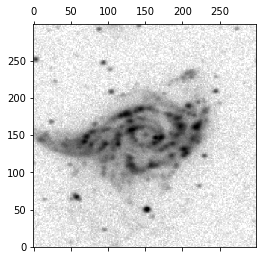

In [ ]:
from pylab import figure, cm
from matplotlib.colors import LogNorm
plt.matshow(dataobj[0].data, origin='lower', cmap=cm.gray_r, norm=LogNorm(vmin=0.005, vmax=0.3))

In [ ]:
x_services=vo.regsearch(servicetype='image',keywords=['chandra'], waveband='x-ray')
print(x_services.to_table()['short_name','ivoid'])

 short_name                 ivoid                 
----------- --------------------------------------
        CDA         ivo://cxc.harvard.edu/cda.siap
        CSC         ivo://cxc.harvard.edu/csc.siap
      CSCR1       ivo://cxc.harvard.edu/cscr1.siap
      CSCR2       ivo://cxc.harvard.edu/cscr2.siap
    Chandra          ivo://nasa.heasarc/chanmaster
GOODSACISFB ivo://nasa.heasarc/skyview/goodsacisfb


In [ ]:
xim_table=x_services[0].search(pos=pos,size=0.2)
print( xim_table.to_table().columns )
first_fits_image_row=xim_table[ int(np.where(np.isin(xim_table.to_table()['imgfmt'],b'image/fits'))[0][0]) ] 

<TableColumns names=('name','instrument','date_obs','ra','dec','naxis','imgscale','imgfmt','accref','filesize','obsid')>


(460.0, 560.0)

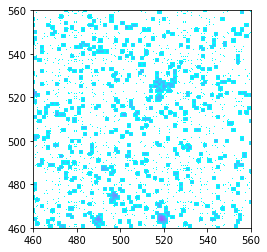

In [ ]:
file_name = download_file(first_fits_image_row.getdataurl(),cache=True)
xhdu_list=fits.open(file_name)


plt.imshow(xhdu_list[0].data, origin='lower', cmap='cool', norm=LogNorm(vmin=0.1, vmax=500.))
plt.xlim(460, 560)
plt.ylim(460, 560)

In [ ]:
xsp_services=vo.regsearch(servicetype='ssa',waveband='x-ray')
xsp_services.to_table()['short_name','ivoid','waveband']

short_name,ivoid,waveband
object,object,object
Chandra,ivo://nasa.heasarc/chanmaster,x-ray
INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,gamma-ray#x-ray
NED/SED,ivo://ned.ipac/sed_data_near_position,radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray
HEAVENS @ ISDC,ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,x-ray#gamma-ray


In [ ]:
xsp_services=vo.regsearch(servicetype='ssa',waveband='x-ray')
xsp_services.to_table()['short_name','ivoid','waveband']

short_name,ivoid,waveband
object,object,object
Chandra,ivo://nasa.heasarc/chanmaster,x-ray
INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,gamma-ray#x-ray
NED/SED,ivo://ned.ipac/sed_data_near_position,radio#millimeter#infrared#optical#uv#euv#x-ray#gamma-ray
HEAVENS @ ISDC,ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,x-ray#gamma-ray


In [ ]:
spec_tables=xsp_services[0].search(pos=pos,radius=0.2,verbose=True)
spec_tables.to_table()

obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_coord_obs,SSA_ra,SSA_dec,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
object,object,object,float64,float64,float64,object,object,float64,object,object,int32,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,float64,float64,float64,float64,float64
17860,archived,M82 X-1,148.95917,69.67972,57639.7292,ACIS-S,HETG,51060,TOO,Walton,58010,57639.7291782407,57640.04039324745,57640.350814633915,51060.0,--,148.95917,69.67972,acisf17860N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/17860/primary/acisf17860N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
19791,archived,M82 X-1,148.95917,69.67972,57641.5702,ACIS-S,HETG,15310,TOO,Walton,58010,57641.5701851852,57641.66802275376,57641.76506558345,15310.0,--,148.95917,69.67972,acisf19791N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19791/primary/acisf19791N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
19792,archived,M82 X-1,148.95917,69.67972,57642.353,ACIS-S,HETG,32440,TOO,Walton,58010,57642.3530092593,57642.55836995486,57642.76294584919,32440.0,--,148.95917,69.67972,acisf19792N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19792/primary/acisf19792N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


In [ ]:
file_name = download_file(spec_tables[0].getdataurl(),cache=True)
hdu_list=fits.open(file_name)

spectra=hdu_list[1].data
print(spectra.columns)
print(len(spectra))

ColDefs(
    name = 'SPEC_NUM'; format = '1I'; null = 0
    name = 'TG_M'; format = '1I'; null = 99
    name = 'TG_PART'; format = '1I'
    name = 'TG_SRCID'; format = '1I'; null = 0
    name = 'X'; format = '1E'; unit = 'pixel'
    name = 'Y'; format = '1E'; unit = 'pixel'
    name = 'CHANNEL'; format = '8192I'; null = 0
    name = 'COUNTS'; format = '8192I'; unit = 'count'; null = -1
    name = 'STAT_ERR'; format = '8192E'; unit = 'count'
    name = 'BACKGROUND_UP'; format = '8192I'; unit = 'count'; null = -1
    name = 'BACKGROUND_DOWN'; format = '8192I'; unit = 'count'; null = -1
    name = 'BIN_LO'; format = '8192D'; unit = 'angstrom'
    name = 'BIN_HI'; format = '8192D'; unit = 'angstrom'
)
12
